In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"            # 라이브러리 충돌을 방지하기 위한 환경 변수 설정
import torch                                         # PyTorch 라이브러리
import torch.nn as nn                                # 신경망을 위한 모듈
import torch.optim as optim                          # 최적화 알고리즘
from torch.utils.data import DataLoader              # 데이터 로딩 유틸리티

from torchvision import datasets, transforms, utils  # 이미지 데이터셋과 변환 도구
import torchvision.utils as vutils                   # 이미지 시각화 유틸리티

import matplotlib.pyplot as plt                      # 그래프와 이미지 출력
import numpy as np                                   # 수치 계산을 위한 라이브러리

In [2]:
# Generator(생성자) 클래스 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # 신경망 계층을 정의하는 nn.Sequential 블록
        self.main = nn.Sequential(
            # 입력: Z 벡터 (임의의 노이즈), ConvTranspose2d는 전치합성곱으로 이미지 크기를 점점 키움
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),  # 출력 크기: 512 채널, 4x4 이미지
            nn.BatchNorm2d(512),  # 배치 정규화
            nn.ReLU(True),  # 활성화 함수

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # 출력 크기: 256 채널, 8x8 이미지
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # 출력 크기: 128 채널, 16x16 이미지
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),  # 출력 크기: 64 채널, 32x32 이미지
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),  # 출력 크기: 3 채널 (RGB), 64x64 이미지
            nn.Tanh()  # 출력값을 -1과 1 사이로 조정
        )

    def forward(self, input):
        return self.main(input)  # forward 패스 정의 (입력을 생성된 이미지로 변환)


In [3]:
# Discriminator(판별자) 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 입력 이미지를 점점 축소시키는 nn.Sequential 블록
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),  # 입력: 3 채널 이미지 (64x64), 출력: 64 채널 (32x32)
            nn.LeakyReLU(0.2, inplace=True),  # 활성화 함수, 음수 값도 보존하는 LeakyReLU

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),  # 출력: 128 채널 (16x16)
            nn.BatchNorm2d(128),  # 배치 정규화
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),  # 출력: 256 채널 (8x8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),  # 출력: 512 채널 (4x4)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),  # 출력: 1 채널, 4x4 이미지에서 1개의 스칼라 값으로 판별
            nn.Sigmoid()  # 0과 1 사이의 값을 출력 (실제 이미지인지 가짜 이미지인지 판별)
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)  # 판별 결과를 반환


In [4]:
# 모델의 가중치 초기화 함수
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:               # Conv 레이어의 경우 가중치를 정규 분포로 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:        # BatchNorm 레이어의 경우 가중치 초기화 후 편향을 0으로 설정
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [5]:
# 생성된 이미지를 시각화하는 함수
def show_generated_images(images, num_images=64):
    plt.figure(figsize=(10, 10))  # 출력될 이미지 크기 설정
    plt.axis("off")  # 축 제거
    plt.title("Generated Images")  # 제목 설정
    images = vutils.make_grid(images[:num_images], padding=2, normalize=True)  # 이미지 그리드 생성
    images = np.transpose(images.cpu(), (1, 2, 0))  # 이미지 채널 순서 변환
    plt.imshow(images)  # 이미지 출력
    plt.show()

# 생성된 이미지를 파일로 저장하는 함수
def save_generated_images(images, num_images, epoch, idx):
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title("Generated Images")
    images = vutils.make_grid(images[:num_images], padding=2, normalize=True)
    images = np.transpose(images.cpu(), (1, 2, 0))
    fname = './output/image_' + str(epoch) + '_' + str(idx) + '.jpg'  # 저장 파일 경로 설정
    plt.imsave(fname, images.numpy())  # 이미지 저장
    plt.close()  # 플롯 닫기


In [6]:
# Create the generator and the discriminator
netG = Generator()
netD = Discriminator()

In [7]:
# Apply the weights_init function to randomly initialize all weights
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [8]:
from torchvision.datasets import ImageFolder

# 데이터 전처리(transform) 정의: 이미지를 64x64로 크기 조정하고, 중앙을 자른 후 텐서로 변환
transform = transforms.Compose([
    transforms.Resize(64),  # 이미지를 64x64 크기로 조정
    transforms.CenterCrop(64),  # 중앙에서 64x64로 자름
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  # RGB 채널별로 [-1, 1] 범위로 정규화
])

def is_valid_file(path):
    # 파일 확장자가 유효한 이미지 파일인지 확인하는 함수
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')
    if any(path.endswith(ext) for ext in valid_extensions):
        return True
    return False

# ImageFolder로 데이터셋을 불러옴. './input/normal_nut' 경로에 이미지 데이터가 있어야 함
dataset = datasets.ImageFolder(root='./input', transform=transform, is_valid_file=is_valid_file)

# DataLoader를 사용해 데이터셋을 배치 단위로 불러옴. 배치 크기는 128, 무작위로 섞음(shuffle=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [9]:
# 장치 설정: CUDA 사용 가능 시 GPU를 사용, 그렇지 않으면 CPU 사용
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 생성자와 판별자 모델을 장치로 이동
netG.to(device)  # Generator(생성자)
netD.to(device)  # Discriminator(판별자)

# 손실 함수로 이진 교차 엔트로피 사용 (진짜/가짜 판별에 적합)
criterion = nn.BCELoss()

# Adam 최적화 알고리즘 설정: 학습률(lr)과 betas는 DCGAN 논문에 따른 설정
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))  # 판별자 최적화기
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))  # 생성자 최적화기

# 학습할 에폭 수 설정 (10은 예시이며, 더 많은 에폭이 필요할 수 있음)
num_epochs = 20

# 학습 중간에 시각화를 위한 고정된 노이즈 텐서 생성
fixed_noise = torch.randn(64, 100, 1, 1, device=device)


In [10]:
# 에폭 수만큼 학습 반복
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):  # 데이터로더에서 배치를 하나씩 가져옴
        # 1. 판별자 업데이트: 진짜 이미지에 대한 D(x)와 가짜 이미지에 대한 D(G(z)) 손실을 최대화
        netD.zero_grad()  # 판별자의 기울기를 0으로 초기화
        real_data = data[0].to(device)  # 실제 데이터를 장치로 이동
        batch_size = real_data.size(0)  # 배치 크기 저장
        real_label = torch.full((batch_size,), 1, dtype=torch.float, device=device)  # 실제 이미지 레이블 (1)
        fake_label = torch.full((batch_size,), 0, dtype=torch.float, device=device)  # 가짜 이미지 레이블 (0)

        # 실제 데이터에 대한 판별자 예측
        output = netD(real_data).view(-1)
        errD_real = criterion(output, real_label)  # 실제 데이터에 대한 손실 계산
        errD_real.backward()  # 역전파로 기울기 계산

        # 2. 생성자로부터 가짜 이미지 생성
        noise = torch.randn(batch_size, 100, 1, 1, device=device)  # 노이즈 벡터 생성
        fake_data = netG(noise)  # 노이즈를 통해 가짜 이미지 생성
        output = netD(fake_data.detach()).view(-1)  # 가짜 이미지를 판별자에 입력

        # 가짜 이미지에 대한 판별자의 손실 계산
        errD_fake = criterion(output, fake_label)  # 가짜 이미지 손실
        errD_fake.backward()  # 역전파로 기울기 계산

        # 실제 이미지와 가짜 이미지 손실을 더한 뒤 판별자 업데이트
        errD = errD_real + errD_fake
        optimizerD.step()  # 판별자 최적화

        # 3. 생성자 업데이트: 판별자를 속이기 위해 손실 최소화 (log(D(G(z)))를 최대화)
        netG.zero_grad()  # 생성자의 기울기 초기화
        output = netD(fake_data).view(-1)  # 생성된 가짜 이미지를 다시 판별자에 입력
        errG = criterion(output, real_label)  # 생성자 손실 (가짜 이미지를 진짜로 판별하도록)
        errG.backward()  # 역전파로 기울기 계산
        optimizerG.step()  # 생성자 최적화

        # 4. 학습 상태 출력 (매 50번째 배치마다 출력)
        if i % 50 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader), errD.item(), errG.item()))
            # fixed_noise = torch.randn(64, 100, 1, 1, device=device)
            fake_images = netG(fixed_noise)
            save_generated_images(fake_images, 64, epoch=epoch, idx=i)


[0/20][0/1] Loss_D: 2.0119 Loss_G: 6.6477
[1/20][0/1] Loss_D: 0.6277 Loss_G: 8.5331
[2/20][0/1] Loss_D: 0.1281 Loss_G: 6.8634
[3/20][0/1] Loss_D: 0.0454 Loss_G: 6.0923
[4/20][0/1] Loss_D: 0.0737 Loss_G: 5.9134
[5/20][0/1] Loss_D: 0.1336 Loss_G: 6.6541
[6/20][0/1] Loss_D: 0.0891 Loss_G: 7.1602
[7/20][0/1] Loss_D: 0.0385 Loss_G: 6.3924
[8/20][0/1] Loss_D: 0.0249 Loss_G: 6.1788
[9/20][0/1] Loss_D: 0.0516 Loss_G: 6.2962
[10/20][0/1] Loss_D: 0.0945 Loss_G: 7.7057
[11/20][0/1] Loss_D: 0.1523 Loss_G: 9.4393
[12/20][0/1] Loss_D: 0.0215 Loss_G: 8.3151
[13/20][0/1] Loss_D: 0.0142 Loss_G: 7.1055
[14/20][0/1] Loss_D: 0.0247 Loss_G: 6.4472
[15/20][0/1] Loss_D: 0.0615 Loss_G: 7.3354
[16/20][0/1] Loss_D: 0.0637 Loss_G: 8.2519
[17/20][0/1] Loss_D: 0.0296 Loss_G: 7.8388
[18/20][0/1] Loss_D: 0.0281 Loss_G: 7.6590
[19/20][0/1] Loss_D: 0.0187 Loss_G: 7.5561


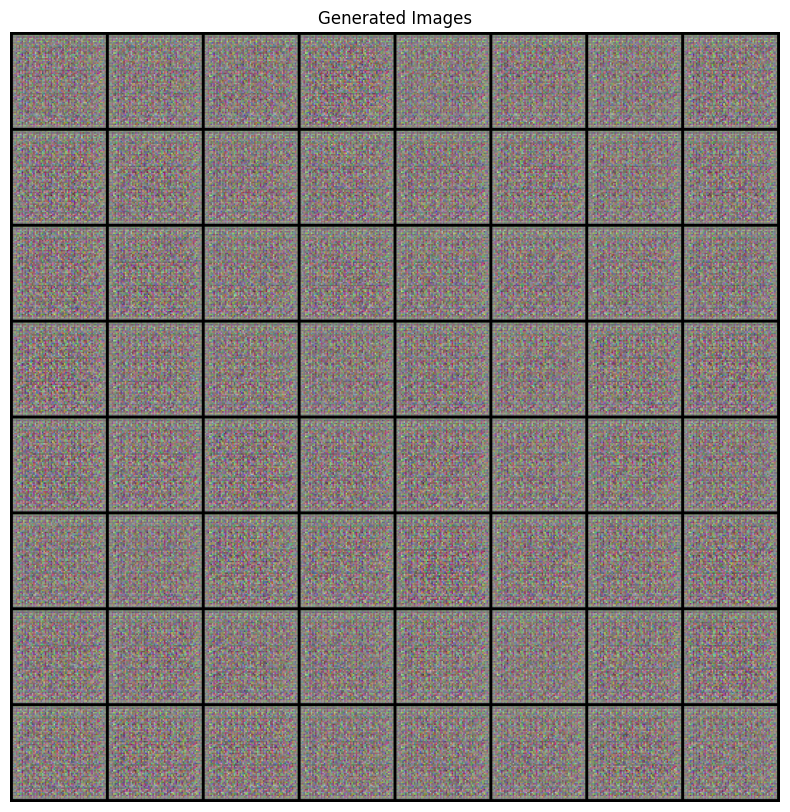

In [12]:
# 고정된 노이즈로 생성된 가짜 이미지를 시각화하는 함수
fake_images = netG(fixed_noise)
show_generated_images(fake_images)
